In [1]:
## Importing packages
import torch
import random
import torch.nn as nn 
import torchvision
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

## Chambolle-Pock algorithm
In this notebook we are going to implement the Chambolle-Pock numerical algorithm for Rudin-Osher-Fatemi Total Variation denoising. 

The algorithm we will be implementing in this notebookk is from \{A First-Order Primal-Dual Algorithm for Convex Problems
 with Applications to Imaging\} specifically the algorithms below:

Algorithm 1 :
* Initialization: Choose $ \tau ,\sigma > 0, \theta \in [0,1], (x^{0},y^{0}) \in \mathcal{X} \times \mathcal{Y}$ and set $\bar{x}^{0} = x^{0}$
* Iterations $(n \geq 0):$ Update $x^{n},y^{n},\bar{x}^{n}$ as follows:
$$ y^{n+1} = (I + \sigma \partial{F^{*}})^{-1} (y^{n} + \sigma K \bar{x}^{n})$$
$$ x^{n+1} = (I + \tau \partial{G})^{-1} (x^{n} + \tau K* y^{n+1}) $$
$$ \bar{x}^{n+1} = x^{n+1} + \theta (x^{n+1} - x^{n}) $$


Algorithm 2 :
* Initialization: Choose $ \tau_{0} ,\sigma_{0} > 0$ with $\tau_{0}\sigma_{0}L^{2} \leq 1$ , $(x^{0},y^{0}) \in \mathcal{X} \times \mathcal{Y}$ and set $\bar{x}^{0} = x^{0}$
* Iterations $(n \geq 0):$ Update $x^{n},y^{n},\bar{x}^{n}, \tau_{n}, \sigma_{n} $ as follows:
$$ y^{n+1} = (I + \sigma \partial{F^{*}})^{-1} (y^{n} + \sigma K \bar{x}^{n})$$
$$ x^{n+1} = (I + \tau \partial{G})^{-1} (x^{n} + \tau K* y^{n+1}) $$
$$ \theta_{n} = 1/\sqrt{1 + 2 \gamma \tau_{n}}$$
$$\tau_{n+1} = \theta_{n} \tau_{n}$$
$$\sigma_{n+1} = \sigma_{n}/ \theta_{n}$$
$$ \bar{x}^{n+1} = x^{n+1} + \theta (x^{n+1} - x^{n}) 


In [2]:
def gradient(image):
    '''
    Calculating the gradient using finite differences

    Parameters:
        image(torch.Tensor): The input image
    Returns:
        image(torch.Tensor): The gradient of the image in x and y respectively
    '''
    if len(image.shape) == 2:  # Add batch and channel dimensions if not present
        image = image.unsqueeze(0).unsqueeze(0)
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)

    # Define finite difference kernels
    # [[-1, 1]] 
    # [[-1], [1]]
    #[[0, 0, 0], [0, -1, 1], [0, 0, 0]]
    #[[0, 0, 0], [0, -1, 0], [0, 1, 0]]
    kernel_x = torch.tensor([[0, 0, 0], [0, -1, 1], [0, 0, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    kernel_y = torch.tensor([[0, 0, 0], [0, -1, 0], [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    grad_x = F.conv2d(image, kernel_x,padding=1)
    grad_y = F.conv2d(image, kernel_y,padding=1)
    return grad_x, grad_y
    



def divergence(p1, p2):
    '''
    Calculating the divergence using finite differences

    Parameters:
        image(torch.Tensor): The input image
    Returns:
        image(torch.Tensor): The divergence of the image in x and y respectively
    '''
    kernel_x = torch.tensor([[0, 0, 0], [0, -1, 1], [0, 0, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    kernel_y = torch.tensor([[0, 0, 0], [0, -1, 0], [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    div_p1 = F.conv_transpose2d(p1, kernel_x,padding=1)
    div_p2 = F.conv_transpose2d(p2, kernel_y,padding=1)
    return div_p1 + div_p2





def chambolle_pock_1(image,lam,tau,sigma,theta, number_iter):
    """
    Chambolle pock algorithm for ROF denoising
    
    Input Parameters:
        image (torch.Tensor): The input image
        number_iter(int): Number of times to repeat the algorithm above
        lam (float): Regularisation parameter 
    
    Returns:
        image (torch.Tensor): The denoised image
    """
    
    #Regularising the image
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension




    #Trying with set parameters tau sigma and theta for now
    #initialization
    x = image.clone()
    y1 = torch.zeros_like(image)
    y2 = torch.zeros_like(image)
    x_bar = x.clone()
    #Iterations and update
    for _ in range(number_iter):
        #Update the variables
        #updating the first equation
        # Update dual variables
        x_bar_grad_x, x_bar_grad_y = gradient(x_bar)
        y1 = y1 + sigma*x_bar_grad_x
        y2 = y2 + sigma*x_bar_grad_y
        norm = torch.sqrt(y1 ** 2 + y2 ** 2).clamp(min=1)
        y1 = y1 / norm
        y2 = y2 / norm
        #updating second equation
        div_y = divergence(y1,y2)
        x_old = x.clone()
        x = (x + tau * lam * (image) - tau*(div_y)) / (1 + tau * lam)
        #updating x_bar
        x_bar = x + theta*(x-x_old)
    return x.squeeze()


    

def chambolle_pock_2(image,lam,tau_n,sigma_n,theta_n,gamma, number_iter,y1,y2):
    """
    Chambolle pock algorithm for ROF denoising
    
    Input Parameters:
        image (torch.Tensor): The input image
        number_iter(int): Number of times to repeat the algorithm above
        lam (float): Regularisation parameter 
    
    Returns:
        image (torch.Tensor): The denoised image
    """
    
    #Regularising the image
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension




    #Trying with set parameters tau sigma and theta for now
    #initialization
    x = image.clone()
    x_bar = x.clone()
    #Iterations and update
    for _ in range(number_iter):
        #Update the variables
        #updating the first equation
        # Update dual variables
        x_bar_grad_x, x_bar_grad_y = gradient(x_bar)
        y1 = y1 + sigma_n*x_bar_grad_x
        y2 = y2 + sigma_n*x_bar_grad_y
        norm = torch.sqrt(y1 ** 2 + y2 ** 2).clamp(min=1)
        y1_new = y1 / norm
        y2_new = y2 / norm
        #updating second equation
        div_y = divergence(y1_new,y2_new)
        x_old = x.clone()
        x = (x + tau_n * lam * (image) - tau_n*(div_y)) / (1 + tau_n * lam)
        #updating theta
        theta_n = 1/(torch.sqrt(torch.tensor(1+2*gamma*tau_n)))
        tau_n = theta_n*tau_n
        sigma_n = sigma_n/theta_n
        #updating x_bar
        x_bar = x + theta_n*(x-x_old)
        #stopping crieterion
        stopping_criterion = 1/2 * ( torch.norm(x - x_old) /torch.norm(x))
        if stopping_criterion < 0.00001:
            return x.squeeze(),y1_new,y2_new
    return x.squeeze(),y1_new,y2_new






In [3]:
##RGB VERSION
##DOESNT WORK (IGNORE)

def gradient_RGB(image):
    """Compute the gradient of the image using finite differences."""
    if len(image.shape) == 2:  # Add batch and channel dimensions if not present
        image = image.unsqueeze(0).unsqueeze(0)
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    channels = image.shape[1]
    kernel_x = torch.tensor([[0, 0, 0], [0, -1, 1], [0, 0, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(channels,1,1,1)
    kernel_y = torch.tensor([[0, 0, 0], [0, -1, 0], [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(channels,1,1,1)
    grad_x = F.conv2d(F.pad(image, (1, 1, 1, 1)), kernel_x, groups=channels)
    grad_y = F.conv_transpose2d(F.pad(image, (-1, -1, -1, -1)), kernel_y, groups=channels)
    return grad_x, grad_y

def divergence_RGB(p1, p2):
    """Compute the divergence of the vector field (p1, p2) using finite differences."""
    channels = p1.shape[1]
    kernel_x = torch.tensor([[1, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
    kernel_y = torch.tensor([[1], [-1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
    div_p1 = F.conv2d(F.pad(p1, (0, 1, 0, 0)), kernel_x, groups=channels)
    div_p2 = F.conv2d(F.pad(p2, (0, 0, 0, 1)), kernel_y, groups=channels)
    return div_p1 + div_p2

def chambolle_pock_rgb(image, lam, tau, sigma, theta, n_iter):
    """
    ROF denoising using Chambolle-Pock algorithm.

    Parameters:
        image (torch.Tensor): The noisy input image (4D tensor: batch_size x channels x height x width).
        lam (float): The regularization parameter.
        tau (float): Primal step size.
        sigma (float): Dual step size.
        theta (float): Over-relaxation parameter.
        n_iter (int): Number of iterations.

    Returns:
        torch.Tensor: The denoised image.
    """
    if len(image.shape) == 2:  # Add batch and channel dimensions if not present
        image = image.unsqueeze(0).unsqueeze(0)
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    x = image.clone()
    p1 = torch.zeros_like(image)
    p2 = torch.zeros_like(image)
    x_bar = x.clone()

    for _ in range(n_iter):
        # Update dual variables
        x_bar_grad_x, x_bar_grad_y = gradient_RGB(x_bar)
        norm = torch.sqrt(x_bar_grad_x ** 2 + x_bar_grad_y ** 2).clamp(min=1)
        p1 = (p1 + sigma * x_bar_grad_x) / norm
        p2 = (p2 + sigma * x_bar_grad_y) / norm

        # Update primal variable
        div_p = divergence_RGB(p1, p2)
        x_old = x.clone()
        x = (x + tau * lam * (image) - (tau*div_p)) / (1 + tau * lam)

        # Over-relaxation
        x_bar = x + theta * (x - x_old)

    return x

## Using a random image to try denoising


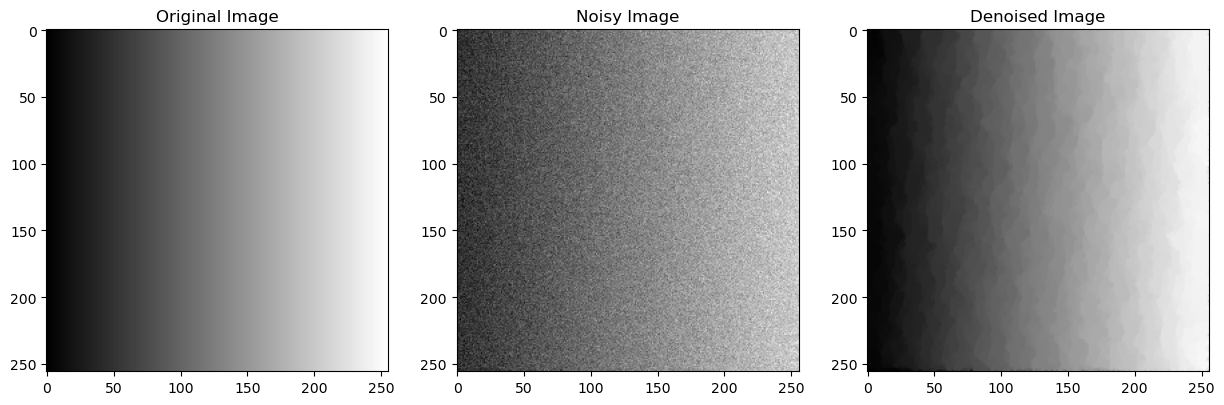

In [4]:
# Create a sample noisy image (e.g., a simple gradient with noise)
torch.manual_seed(0)
image = torch.linspace(0, 1, steps=256).repeat(256, 1)  # Create a sample gradient image
noisy_image = image + 0.1 * torch.randn_like(image)

# Denoise the image using PDHG algorithm
lam = 7
tau = 0.08
sigma = 1.0/(lam*tau)
theta = 1.0
n_iter = 1000 #50 
denoised_image = chambolle_pock_1(noisy_image, lam, tau, sigma,theta, n_iter)




# Plot the original, noisy, and denoised images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image.numpy(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image.numpy(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_image.numpy(), cmap='gray')
plt.show()

In [5]:
image = torchvision.io.read_image(path='images\KnutSteen.jpg',mode= torchvision.io.ImageReadMode.GRAY).float().squeeze(0)/255 # Create a sample gradient image
image_rgb = torchvision.io.read_image(path='images\KnutSteen.jpg',mode= torchvision.io.ImageReadMode.RGB).float().squeeze(0)/255
noisy_image = image + 0.15 * torch.randn_like(image)
noisy_image_rgb  = image_rgb + 0.15 * torch.randn_like(image)

# Denoise the image using PDHG algorithm
lam = 7
tau = 0.08
sigma = 1.0/(lam*tau)
theta = 1.0
gamma = 0.35*lam
n_iter = 1000 #50 
print('Starting denoising')
denoised_image_1 = chambolle_pock_1(noisy_image.float(), lam, tau, sigma,theta, n_iter)
denoised_image_2,_,_ = chambolle_pock_2(noisy_image.float(), lam, tau, sigma,theta,gamma, 1000,torch.zeros_like(image),torch.zeros_like(image))

Starting denoising


C:\Users\aungf\AppData\Local\Temp\ipykernel_14792\3865919313.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_n = 1/(torch.sqrt(torch.tensor(1+2*gamma*tau_n)))


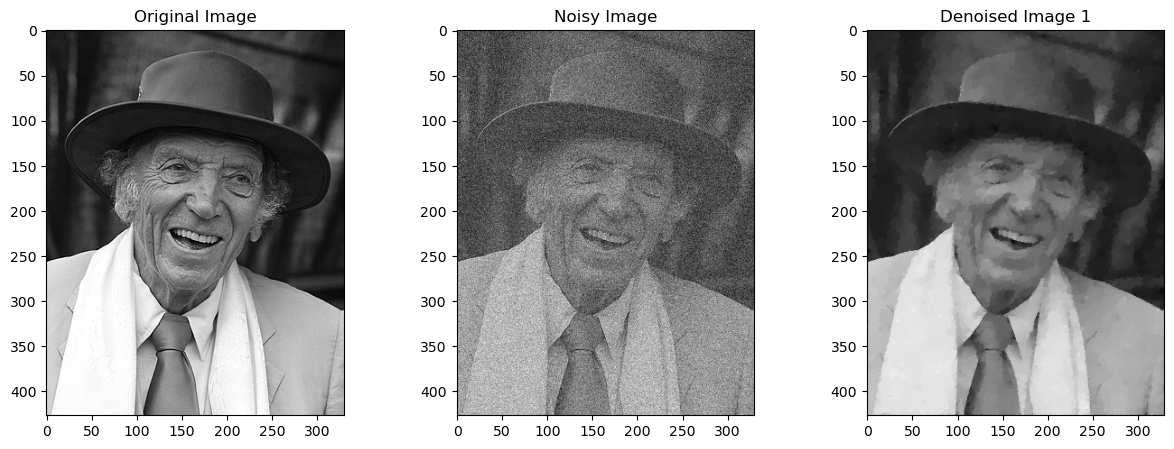

In [6]:
# Plot the original, noisy, and denoised images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image.numpy(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image.numpy(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Denoised Image 1')
#denoised_image_1 = denoised_image_1.squeeze()
#transform = torchvision.transforms.ToPILImage()
plt.imshow(denoised_image_1.numpy(), cmap='gray')
#plt.subplot(1, 4, 4)
#plt.title('Denoised Image 2')
#plt.imshow(denoised_image_2.numpy(), cmap='gray')
plt.show()

## Total Variation Spectral Framework by Guy Gilboa

For the denoising algorithms above we will be using Guy Gilboa's paper "A Total Variation Spectral Framework" by Guy Gilboa.   

In [7]:
## Given a basic image we will keep applying chamboelle pock on the image to get our desired result
N = 20
height,width = image.shape
u_n = torch.zeros((N+1,height,width))
u_n[0] = image
y1 = torch.zeros_like(image)
y2 = torch.zeros_like(image)
for i in range(N):
    u_n[i+1],y1,y2 = chambolle_pock_2(u_n[i],lam,tau,sigma,theta,gamma,5000,y1,y2)

def phi(n,u_n):
    return n*(u_n[n-1] + u_n[n+1]-2*u_n[n]) 

def phi_sum(N,u_n):
    return u_n[0] - (N+1)*u_n[N] + N*u_n[N+1]

def f_r(n,u_n):
    return (n+1)*u_n[n] - n*u_n[n+1]

def S(n,u_n):
    return torch.sum(torch.abs(phi(n,u_n)))


def desired_spectral_components(start,end,u_n):
    '''
    Put range of values you would like to change
    start - end(not included)
    '''
    phi_old = 0
    phi_new = 0
    for i in range(start,end):
        phi_old += phi(i,u_n)
        phi_new += random.randrange(10,20)*phi(i,u_n)
    return phi_new - phi_old


 





C:\Users\aungf\AppData\Local\Temp\ipykernel_14792\3865919313.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_n = 1/(torch.sqrt(torch.tensor(1+2*gamma*tau_n)))


In [8]:
w_N = phi_sum(N-2,u_n)  + desired_spectral_components(1,4,u_n) + f_r(N-2,u_n) 

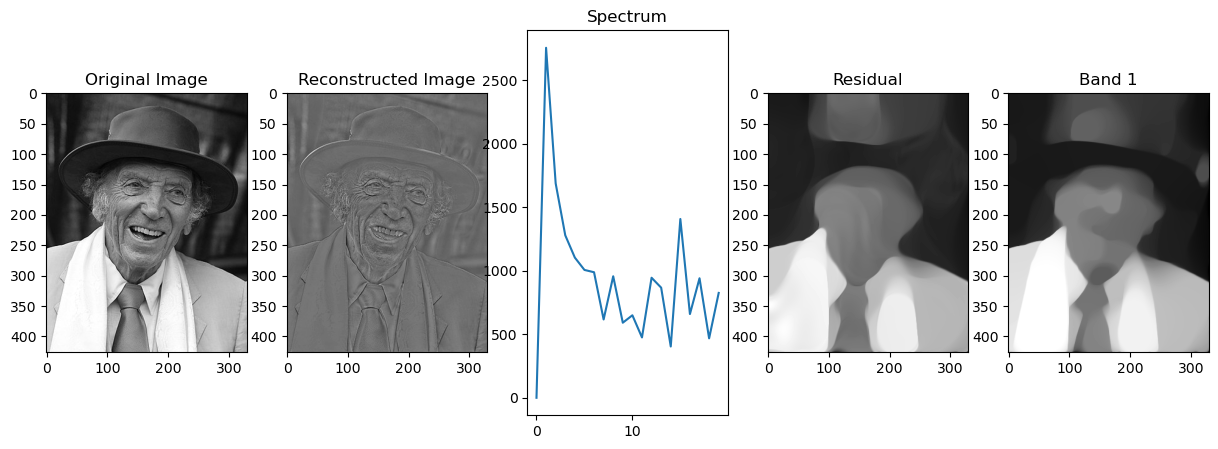

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(image.numpy(), cmap='gray')
plt.subplot(1,5,2)
plt.title('Reconstructed Image')
plt.imshow(w_N.numpy(), cmap='gray')
plt.subplot(1,5,3)
plt.title('Spectrum')
spec_plot = []
for i in range(N):
    spec_plot.append(S(i,u_n))
plt.plot(spec_plot)
plt.subplot(1,5,4)
plt.title('Residual')
plt.imshow(f_r(N-2,u_n).numpy(),cmap='gray')
plt.subplot(1,5,5)
plt.title('Band 1')
plt.imshow(100*u_n[6].numpy(),cmap='gray')
plt.show()